----------------------------------------------------------------------------------------------------------------------
# Clustering
----------------------------------------------------------------------------------------------------------------------
## Project-Segmenting customers into clusters

### Perform Customer Segmentation on the transactional data to build an efficient marketing model. This is a transactional data set that contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a registered non-store online retail.

### Invoice No: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with the letter 'c', it indicates a cancellation.

### StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

### Description: Product (item) name. Nominal.

### Quantity: The quantities of each product (item) per transaction. Numeric.

### Invoice Date: Invoice Date and time. Numeric, the day and time when each transaction was generated.

### UnitPrice: Unit price. Numeric, Product price per unit in sterling.

### CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

### Country: Country name. Nominal, the name of the country where each customer resides

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
file_path = r'D:\data science\Job Folder\ujjwal/transactions_sample.xlsx'

# Read the sheets into DataFrames
sheet1 = pd.read_excel(file_path, sheet_name='Year 2009-2010')
sheet2 = pd.read_excel(file_path, sheet_name='Year 2010-2011')

In [3]:
# Concatenate the DataFrames
combined_df = pd.concat([sheet1, sheet2])

In [4]:
combined_df.head(2)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom


In [5]:
#Checking null values
combined_df.isna().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [6]:
#Drop Na values
combined_df.dropna(inplace= True)
combined_df.shape

(824364, 8)

In [27]:
# Make a copy of dataframe
merged_df= combined_df.copy()

In [28]:
# Let's remove the cancelled product
df_Invoice = pd.DataFrame({"Invoice":[row for row in merged_df["Invoice"].values if "C"  not in str(row)]})
df_Invoice.head()
df_Invoice = df_Invoice.drop_duplicates("Invoice")

# The transactions except returned product transactions
combined_df = combined_df.merge(df_Invoice, on = "Invoice")

In [29]:
merged_df['StockCode'].nunique()

4631

In [30]:
merged_df['Description'].nunique()

5283

In [31]:
#The unique values of these 2 variables (Description & StockCode) should be equal, because each stock code represents a product.

# 1st Step
df_product = merged_df[["Description","StockCode"]].drop_duplicates()
df_product = df_product.groupby(["Description"]).agg({"StockCode":"count"}).reset_index()

df_product.rename(columns={'StockCode':'StockCode_Count'},inplace=True)
df_product.head()

,Description,StockCode_Count
0,DOORMAT UNION JACK GUNS AND ROSES,1
1,3 STRIPEY MICE FELTCRAFT,1
2,4 PURPLE FLOCK DINNER CANDLES,1
3,50'S CHRISTMAS GIFT BAG LARGE,1
4,ANIMAL STICKERS,1


In [32]:
df_product = df_product.sort_values("StockCode_Count", ascending=False)
df_product = df_product[df_product["StockCode_Count"]>1]
df_product.head()

,Description,StockCode_Count
2719,"METAL SIGN,CUPCAKE SINGLE HOOK",3
1119,COLOURING PENCILS BROWN TUBE,3
5015,WHITE BAMBOO RIBS LAMPSHADE,3
1121,COLUMBIAN CANDLE RECTANGLE,2
2805,MODERN CHRISTMAS TREE CANDLE,2


In [33]:
# Let's delete products with more than one stock code 

merged_df = merged_df[~merged_df["Description"].isin(df_product["Description"])]

print(merged_df.StockCode.nunique())
print(merged_df.Description.nunique())

4582
5254


In [34]:
# 2nd Step

df_product = merged_df[["Description","StockCode"]].drop_duplicates()
df_product = df_product.groupby(["StockCode"]).agg({"Description":"count"}).reset_index()
df_product.rename(columns={'Description':'Description_Count'},inplace=True)
df_product = df_product.sort_values("Description_Count", ascending=False)
df_product = df_product[df_product["Description_Count"] > 1] 


df_product.head()

,StockCode,Description_Count
2222,23196,4
1085,21955,4
98,20685,4
1415,22346,4
2262,23236,4


In [35]:
# Let's delete stock codes that represent multiple products

merged_df = merged_df[~merged_df["StockCode"].isin(df_product["StockCode"])]
# Now each stock code represents a single product

print(merged_df.StockCode.nunique())
print(merged_df.Description.nunique())

3969
3969


### RFM Analysis

In [36]:
#Calculate Total Price
merged_df['TotalPrice'] = merged_df['Quantity'] * merged_df['Price']

In [37]:
# Monetary
rfm_m= merged_df.groupby('Customer ID')['TotalPrice'].sum()
rfm_m=rfm_m.reset_index()
rfm_m.head()

,Customer ID,TotalPrice
0,12346.0,77259.83
1,12347.0,4544.94
2,12348.0,1823.68
3,12349.0,2756.42
4,12350.0,273.80


In [38]:
# Frquency
rfm_f= merged_df.groupby('Customer ID')['Invoice'].count()
rfm_f=rfm_f.reset_index()
rfm_f=rfm_f.rename(columns={'Invoice':'Frequency'})
rfm_f.head()

,Customer ID,Frequency
0,12346.0,12
1,12347.0,199
2,12348.0,43
3,12349.0,106
4,12350.0,14


In [39]:
# Merging these two dfs
rfm= pd.merge(rfm_m,rfm_f,on='Customer ID',how= 'inner')
rfm.head()

,Customer ID,TotalPrice,Frequency
0,12346.0,77259.83,12
1,12347.0,4544.94,199
2,12348.0,1823.68,43
3,12349.0,2756.42,106
4,12350.0,273.80,14


In [40]:
# Extracting date only from InvoiceDate column
merged_df['InvoiceDate']=merged_df['InvoiceDate'].dt.date

# Most recent transaction date
max_date= max(merged_df['InvoiceDate'])

# creatinng a new column diff for calculating the diffrence between max date and invoice date
merged_df['diff'] = max_date- merged_df['InvoiceDate']

merged_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,diff
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01,6.95,13085.0,United Kingdom,83.4,738 days
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01,6.75,13085.0,United Kingdom,81.0,738 days
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01,2.10,13085.0,United Kingdom,100.8,738 days
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01,1.65,13085.0,United Kingdom,39.6,738 days
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01,1.25,13085.0,United Kingdom,30.0,738 days


In [42]:
# Recency
rfm_r= merged_df.groupby('Customer ID')['diff'].min()
rfm_r= rfm_r.reset_index()
rfm_r.head()

,Customer ID,diff
0,12346.0,325 days
1,12347.0,2 days
2,12348.0,75 days
3,12349.0,18 days
4,12350.0,310 days


In [43]:
# Merge the datframe of recency, frequency and monetary
rfm=pd.merge(rfm, rfm_r, on='Customer ID',how='inner')
rfm=rfm.rename(columns={'diff': 'recency','TotalPrice':'Monetary'})
rfm.head()

,Customer ID,Monetary,Frequency,recency
0,12346.0,77259.83,12,325 days
1,12347.0,4544.94,199,2 days
2,12348.0,1823.68,43,75 days
3,12349.0,2756.42,106,18 days
4,12350.0,273.80,14,310 days


In [44]:
rfm['recency']=rfm['recency'].dt.days
rfm.head()

,Customer ID,Monetary,Frequency,recency
0,12346.0,77259.83,12,325
1,12347.0,4544.94,199,2
2,12348.0,1823.68,43,75
3,12349.0,2756.42,106,18
4,12350.0,273.80,14,310


Text(0.5, 0, 'Attributes')

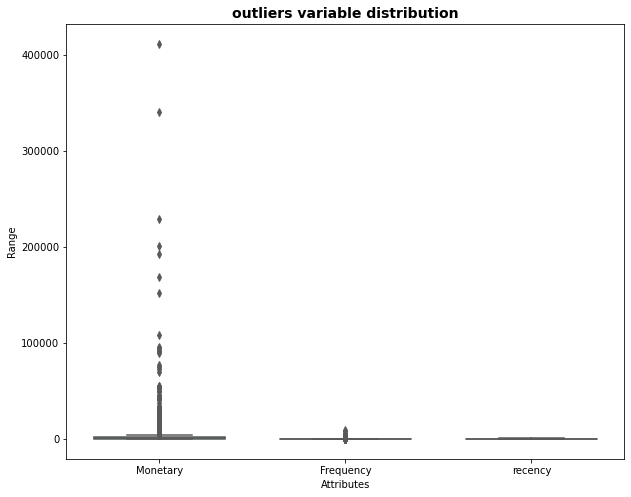

In [45]:
# Outlier Detection of RFM dataframe
attributes= ['Monetary','Frequency','recency']
plt.figure(figsize=(10,8))
sns.boxplot(data=rfm[attributes],orient='v',palette= 'Set2',whis=1.5,saturation=1, width=0.7)
plt.title('outliers variable distribution', fontsize=14, fontweight='bold')
plt.ylabel("Range")
plt.xlabel('Attributes')

In [46]:
# Removal of Outlier for Monetary
q1= rfm['Monetary'].quantile(0.05)
q3= rfm['Monetary'].quantile(0.95)
IQR= q3-q1
rfm= rfm[(rfm.Monetary>= q1 - 1.5*IQR) & (rfm.Monetary<= q3 + 1.5*IQR)]

# Removal of Outlier for Frequency
q1= rfm['Frequency'].quantile(0.05)
q3= rfm['Frequency'].quantile(0.95)
IQR= q3-q1
rfm= rfm[(rfm.Frequency>= q1 - 1.5*IQR) & (rfm.Frequency<= q3 + 1.5*IQR)]

# Removal of Outlier for Recency
q1= rfm['recency'].quantile(0.05)
q3= rfm['recency'].quantile(0.95)
IQR= q3-q1
rfm= rfm[(rfm.recency>= q1 - 1.5*IQR) & (rfm.recency<= q3 + 1.5*IQR)]

## Scaling the features

In [47]:
rfm_df=rfm [['Monetary','Frequency','recency']]

# Instantiate the standard scaler
SS= StandardScaler()

#Fit_transform
rfm_scaled= SS.fit_transform(rfm_df)
rfm_scaled.shape

(5715, 3)

In [48]:
rfm_scaled=pd.DataFrame(rfm_scaled)
rfm_scaled.columns= ['Monetary','Frequency','recency']

In [49]:
rfm_scaled.head(2)

,Monetary,Frequency,recency
0,1.462682,0.977373,-0.962761
1,0.182897,-0.354069,-0.613691


## Model Building

In [50]:
# Applying K- Means Clustering
kmeans= KMeans(n_clusters=3, max_iter=150)
kmeans.fit(rfm_scaled)

KMeans(max_iter=150, n_clusters=3)

In [51]:
kmeans.labels_

array([2, 1, 1, ..., 0, 0, 1])

In [52]:
rfm['Clusters']= kmeans.labels_

In [53]:
rfm.head()

,Customer ID,Monetary,Frequency,recency,Clusters
1,12347.0,4544.94,199,2,2
2,12348.0,1823.68,43,75,1
3,12349.0,2756.42,106,18,1
4,12350.0,273.80,14,310,0
5,12351.0,214.68,16,375,0


In [56]:
Clusters_group=rfm.groupby(['Clusters'])['Monetary','Frequency','recency'].mean()
Clusters_group

,Monetary,Frequency,recency
Clusters,,,
0,482.272727,30.662141,466.190078
1,1108.099759,66.552324,75.845084
2,5920.377981,335.334380,46.207221


In [57]:
def func(row):
    if row['Clusters']==0:
        return 'Whales'
    elif row['Clusters']==1:
        return 'Average Customers'
    else:
        return 'Ocassionaly Buyers'

In [58]:
rfm['segments']= rfm.apply(func,axis=1)

In [59]:
rfm.head()

,Customer ID,Monetary,Frequency,recency,Clusters,segments
1,12347.0,4544.94,199,2,2,Ocassionaly Buyers
2,12348.0,1823.68,43,75,1,Average Customers
3,12349.0,2756.42,106,18,1,Average Customers
4,12350.0,273.80,14,310,0,Whales
5,12351.0,214.68,16,375,0,Whales


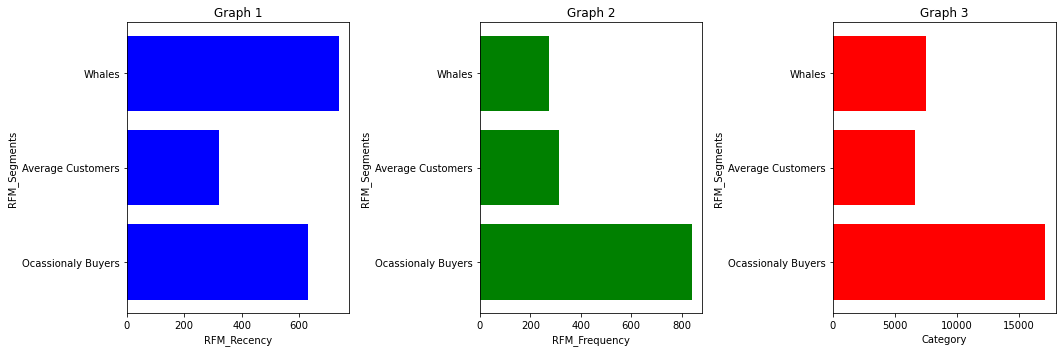

In [60]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first graph
axs[0].barh(rfm['segments'], rfm['recency'], color='blue')
axs[0].set_title('Graph 1')
axs[0].set_xlabel('RFM_Recency')
axs[0].set_ylabel('RFM_Segments')

# Plot the second graph
axs[1].barh(rfm['segments'], rfm['Frequency'], color='green')
axs[1].set_title('Graph 2')
axs[1].set_xlabel('RFM_Frequency')
axs[1].set_ylabel('RFM_Segments')

# Plot the third graph
axs[2].barh(rfm['segments'], rfm['Monetary'], color='red')
axs[2].set_title('Graph 3')
axs[2].set_xlabel('Category')
axs[2].set_ylabel('RFM_Segments')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()